# Amazon Fine Food Reviews


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review

## Importing libraries and loading the dataset :
* Cleaning and handling deduplication of data is already performed.

In [1]:
!pip install nltk
!pip install seaborn
!pip install xgboost
!pip install gensim

    100% |################################| 1.4MB 9.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built nltk
jupyter 1.0.0 requires qtconsole, which is not installed.
ipywidgets 7.0.3 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.2.1 which is incompatible.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 215kB 6.5MB/s ta 0:00:01
jupyter 1.0.0 requires qtconsole, which is not installed.
ipywidgets 7.0.3 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.2.1 which is incompatible.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |############

  Running setup.py bdist_wheel for gensim ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/26/7b/c6/8f29903415a88fc8c9fb99c6c027684d5ce7e6da98cf71a5b9
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/73/f1/9b/ccf93d4ba073b6f79b1ed9df68ab5ce048d8136d0efcf90b30
  Running setup.py bdist_wheel for bz2file ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built gensim smart-open bz2file
jupyter 1.0.0 requires qtconsole, which is not installed.
ipywidgets 7.0.3 has requirement widgetsnbextension~=3.0.0, but you'll have widgetsnbextension 3.2.1 which is incompatible.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn import datasets, neighbors
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import gensim
plt.style.use('fivethirtyeight')

/opt/conda/envs/py3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
conn = sqlite3.connect('final.sqlite')
data = pd.read_sql_query("""
SELECT *
FROM Reviews""", conn)
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [4]:
data.shape

(364171, 12)

In [5]:
# Sampling the data :
pos_data = data[data['Score'] == 'positive'][:2500]
neg_data = data[data['Score'] == 'negative'][:2500]
sample_data = pd.concat([pos_data, neg_data])
sample_data['Score'].value_counts()

positive    2500
negative    2500
Name: Score, dtype: int64

In [6]:
sample_data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [7]:
# Removing the score column as it is not needed.
sample_data = sample_data.drop('Score', axis = 1)
sample_data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


## Bag of Words (BoW) :

In [8]:
# Generating bag of words features.
count_vect = CountVectorizer()
bow = count_vect.fit_transform(sample_data['CleanedText'].values)
bow.shape

(5000, 10430)

### Applying K-Means -:

In [9]:
# Importing k-Means class from sklearn
from sklearn.cluster import KMeans

In [10]:
# Number of clusters to check.
num_clus = [x for x in range(3,11)]
num_clus

[3, 4, 5, 6, 7, 8, 9, 10]

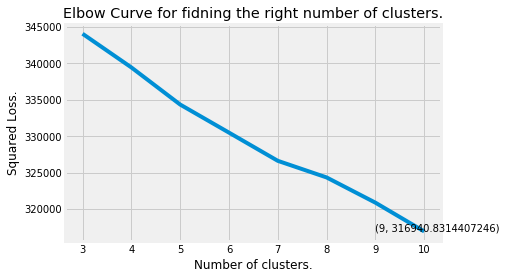

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  316940.8314407246


In [11]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1).fit(bow) # Training Clustering.
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

> The Optimal number of clusters - ** 10 **<br>
> The Loss for optimal cluster value - **316940.83**

In [12]:
# Training the best model --
model = KMeans(n_clusters = optimal_clusters, n_jobs = -1)
model.fit(bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [13]:
# Giving Labels/assigning a cluster to each point/text 
df = sample_data
df['Bow Clus Label'] = model.labels_
df.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText,Bow Clus Label
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,8
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...,8


In [14]:
# How many points belong to each cluster ->
df.groupby(['Bow Clus Label'])['Text'].count()

Bow Clus Label
0      38
1      39
2     299
3      38
4      52
5     373
6     379
7       1
8    3781
Name: Text, dtype: int64

> Most of the points belong to cluster number 9 or 1.<br>
> The least number of points belong to cluster number 3 only 1 point.

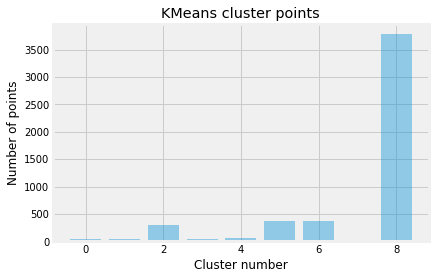

In [15]:
plt.bar([x for x in range(optimal_clusters)], df.groupby(['Bow Clus Label'])['Text'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [16]:
# Reading a review which belong to each group.
for i in range(optimal_clusters):
    print("A review of assigned to cluster ", i)
    print("-" * 70)
    print(df.iloc[df.groupby(['Bow Clus Label']).groups[i][0]]['Text'])
    print('\n')
    print("_" * 70)

A review of assigned to cluster  0
----------------------------------------------------------------------
Have 2 rescues and just switched to this according to other reviews. They ate it up and the price was right.<a href="http://www.amazon.com/gp/product/B000084F1I">Diamond Naturals Dry Food for Adult Dog, Beef and Rice Formula, 40 Pound Bag</a>


______________________________________________________________________
A review of assigned to cluster  1
----------------------------------------------------------------------
My dog loves the Nylabone Dental Dinosaur! Our vet recommends them for keeping the molars clean and the work. Highly recommend this product.


______________________________________________________________________
A review of assigned to cluster  2
----------------------------------------------------------------------
I just used these for the first time when decorating gingerbread cookies for a chidlren's holiday party.  Mixed with royal icing, the colors were much m

** Conclusions **
1. Looking at the clusters we can see that some of the reviews which are not related are kept in different clusters.
2. But some of these like reviews about dogs should be kept in one cluster but they are in different clusters like cluster 6 and cluster 3 both have a review about dog.
<br>
### K-Medoids :-

In [17]:
# This KMedoids file is obtained from -> https://github.com/letiantian/kmedoids
import kmedoids
from sklearn.metrics import pairwise_distances

In [18]:
# Converting to dataframe to array.
bow = bow.toarray()
bow.shape

(5000, 10430)

In [19]:
# Computing pariwise distances.
D = pairwise_distances(bow, metric='euclidean')
D.shape

(5000, 5000)

In [20]:
# For finding optimal value of number of clusters.
def compute_loss(M, C, data): # Squared Loss. !!
    loss = 0.0
    for key, arr in C.items():
        for pos in arr:
            loss = loss + ((data[M[key]] - data[pos]).sum()) ** 2
    
    return loss

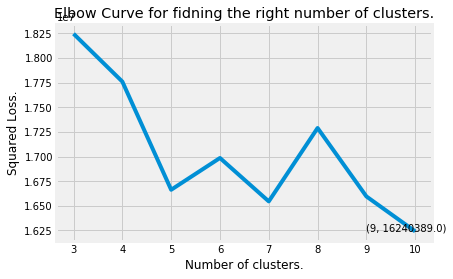

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  16240389.0


In [21]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    M, C = kmedoids.kMedoids(D, cluster) # Training Clustering.
    squared_errors.append(compute_loss(M, C, bow)) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [22]:
M, C = kmedoids.kMedoids(D, k = optimal_clusters) # Using optimal_cluster to best kmedoid.

In [23]:
# Looking at cluster center and a point near them.
q = 0
for i in M:
    print ("Cluster ", q)
    print (" ")
    print (sample_data.iloc[i]['Text'])
    print ("\nA Review belonging to this cluster. -> \n")
    print (sample_data.iloc[C[q][0]]['Text'])
    print ("\n")
    print ("*" * 90)
    q = q + 1

Cluster  0
 
I had used this product before and it worked great for cleaning and maintenance for my pet's ears.

A Review belonging to this cluster. -> 

Its a great product, and our dog loves them.  But I see that Amazon lists some sellers of "used and new".....I wouldn't recommend buying these used.


******************************************************************************************
Cluster  1
 
My dogs love these... either straight up, or crumbled on food they would otherwise not eat.  They don't get sick of them and almost never ever reject them.  They do quite often reject other treats, and certainly after a while of the same other treats.  But then tend to always enjoy these. In fact, I have to be careful not to over feed them these because I don't know if they are healthy to eat in quantity.  Certainly not for my wallet.  They do last a LONG time though, especially compare to their weight.  However, dogs wolf them down quite quickly.  I highly recommend you reward you do

In [24]:
# Plotting Number of points in each cluster .
counts = []
for key, arr in C.items():
    counts.append(len(arr))
counts

[299, 22, 1, 66, 149, 31, 47, 2, 4383]

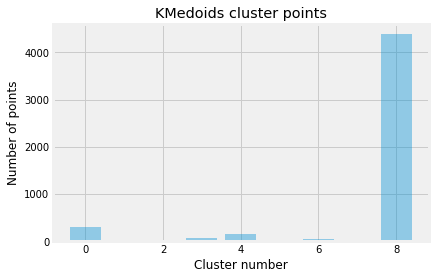

In [25]:
plt.bar([x for x in range(optimal_clusters)], counts, alpha = 0.4)
plt.title('KMedoids cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

** Conclusions **
1. KMedoid loss is a lot higher than KMeans loss.
2. Most of the points almost 90+% belong to cluster 8. ( 0 based indexing )
3. Also the medoids just does a decent job in clustering just like KMEANS.
4. Some of the cluster centers and a review belonging to that cluster are not same example cluster number 8.

### Heirarchical Clustering :

In [26]:
# Importing Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

In [27]:
# Checking agglomerative Clustering groupings ->
df = sample_data
for cluster in num_clus:
    agg = AgglomerativeClustering(n_clusters=cluster)
    agg.fit(bow)
    print("*" * 40, "  For Number of Clusters = ", cluster, "  ", "*" * 40)
    print("\nReviews for each of the clusters : \n")
    df = sample_data
    df['Clst'] = agg.labels_
    df = df.groupby(['Clst'])
    # Printing two reviews from each cluster, if they contain at-least points.
    for i in range(cluster):
        print("For cluster ", i, "\n")
        print("Review 1 -> \n")
        print(sample_data.iloc[df.groups[i][0]]['Text'])
        if(len(df.groups[i]) > 1):
            print("\n")
            print("Review 2 -> \n")
            print(sample_data.iloc[df.groups[i][1]]['Text'])
        print("-" * 80)
    
    print("_" * 80)
    print("\n")

****************************************   For Number of Clusters =  3    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

Set in a small New England town, Tim Burton's masterpiece &quot;Beetlejuice&quot; follows the life of Adam and Barbara Maitlin, owners of a large house and small hardware store. While taking a vacation at home, the couple drowns in a mishap car accident. When their home is taken over by boisterous city-folk, they turn in several directions for help  in haunting the Deets family. One such prospective poltergeist is Beetlejuice- brilliantly played by Michael Keaton. <p>Featuring a star-studded cast including a young Winona Ryder, Geena Davis, Alec Baldwin and of course Keaton, the storyline boasts creative, believable characters simply not seen in movies these days. <p>Everything in the storyline is clever, from props to costumes right down the score. One of my absolute favorite films!


Review 2 -> 

Halle

****************************************   For Number of Clusters =  4    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

Set in a small New England town, Tim Burton's maste

****************************************   For Number of Clusters =  5    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

I bought one of these to start and both my dogs loved it, so I bought another one so they didn't have to try and share one. I got lucky and actually ended up with two different styles of dinosaur. I love nylabone products and will probably put another dino in my amazon cart soon!


Review 2 -> 

I have a six month pup that is about 35 pounds and chews EVERYTHING!  Totally demolishes whatever she can get her hands on!  I'm hoping this helps satisfy her chewing needs without being destroyed. It looks great and is exactly what I was wanting so fingers are crossed! :-)
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

Set in a small New England town, Tim Burton's masterpiece &quot;Beetlejuice&quot; follows the life of Adam and Barbara Maitlin, owne

****************************************   For Number of Clusters =  6    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

Set in a small New England town, Tim Burton's maste

****************************************   For Number of Clusters =  7    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

Set in a small New England town, Tim Burton's masterpiece &quot;Beetlejuice&quot; follows the life of Adam and Barbara Maitlin, owners of a large house and small hardware store. While taking a vacation at home, the couple drowns in a mishap car accident. When their home is taken over by boisterous city-folk, they turn in several directions for help  in haunting the Deets family. One such prospective poltergeist is Beetlejuice- brilliantly played by Michael Keaton. <p>Featuring a star-studded cast including a young Winona Ryder, Geena Davis, Alec Baldwin and of course Keaton, the storyline boasts creative, believable characters simply not seen in movies these days. <p>Everything in the storyline is clever, from props to costumes right down the score. One of my absolute favorite films!


Review 2 -> 

Halle

****************************************   For Number of Clusters =  8    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

These liver treas are phenomenal. When i received the 14oz. bucket by amazon i began training my 3month old Alaskan malamute. Now that a month has passed by, she now knows: Sit, Stay, Down, Paw, & SPEAK! My bucket is almost empty as it only lasted for about a month but was worth every penny as ive read malamutes are very stubborn quite dogs. I gave some to my 2 poodles where they gobbled it down and were begging for more. These treats are highly recommended, plus the liver cubes can be further broken down into quadrants. A+++ product


Review 2 -> 

No waste , even if she is having a  day when she goes on a hunger strike  she always room for one or 2 or 3 of these and the extra powder on bottom makes a real treat on food , Never met a pooch that did not go crazy over her treats !
-------------------------

****************************************   For Number of Clusters =  9    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

My dogs love Zuke's Hip Action Treats.<br /><br />I don't know if you realized it or not but the individual bags you were selling were cheaper than the three pack.


Review 2 -> 

My two Chihuahuas absolutely love these treats. They get one at bedtime and follow me around until I give it to them. These are great healthy moist treats for a good price. Would highly recommend.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

These seems to work as promised. I have used one for years and recently had to replace, due to changing circumstances. This model comes with 4 stoppers, and the pump is attractive and well made. Since I almost never finish a whole bottle of wine, one of these is essential for preserving the remainder.


Review 2 -> 

If you'r

****************************************   For Number of Clusters =  10    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

These seems to work as promised. I have used one for years and recently had to replace, due to changing circumstances. This model comes with 4 stoppers, and the pump is attractive and well made. Since I almost never finish a whole bottle of wine, one of these is essential for preserving the remainder.


Review 2 -> 

If you're new to this product you need to be very careful of dosage. It is strong. Some batches are stronger than others.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

My dogs love Zuke's Hip Action Treats.<br /><br />I don't know if you realized it or not but the individual bags you were selling were cheaper than the three pack.


Review 2 -> 

My two Chihuahuas absolutely love these treats. They get one at bedtime and follow

** Observations **
1. Again some reviews which have been clustered are entirely different but some of them are grouped nicely.

## TFIDF :

In [28]:
tfidf_vect = TfidfVectorizer()
tfidf = count_vect.fit_transform(sample_data['CleanedText'].values)
tfidf.shape

(5000, 10430)

### K-Means :

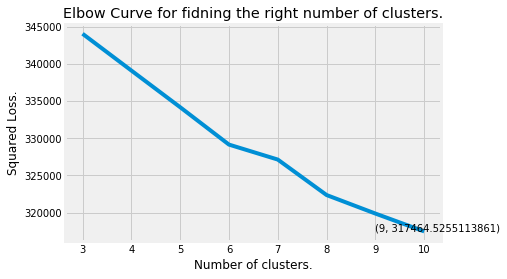

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  317464.5255113861


In [29]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster, n_jobs = -1).fit(tfidf) # Training Clustering.
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [30]:
# Training the best model --
model = KMeans(n_clusters = optimal_clusters, n_jobs = -1)
model.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [31]:
# Giving Labels/assigning a cluster to each point/text 
df = sample_data
df['Tfidf Clus Label'] = model.labels_
df.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText,Bow Clus Label,Clst,Tfidf Clus Label
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,8,6,7
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...,8,6,7


In [32]:
# How many points belong to each cluster ->
df.groupby(['Tfidf Clus Label'])['Text'].count()

Tfidf Clus Label
0     604
1     189
2      53
3      43
4     414
5     109
6      73
7    3514
8       1
Name: Text, dtype: int64

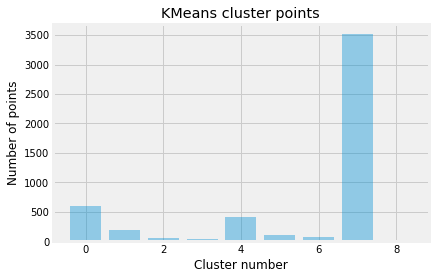

In [33]:
plt.bar([x for x in range(optimal_clusters)], df.groupby(['Tfidf Clus Label'])['Text'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [34]:
# Reading a review which belong to each group.
for i in range(optimal_clusters):
    print("A review of assigned to cluster ", i)
    print("-" * 70)
    print(df.iloc[df.groupby(['Tfidf Clus Label']).groups[i][0]]['Text'])
    print('\n')
    print("_" * 70)

A review of assigned to cluster  0
----------------------------------------------------------------------
This is a great little book to read aloud- it has a nice rhythm as well as good repetition that little ones like, in the lines about "chicken soup with rice".  The child gets to go through the months of the year and go to wonderful places like Bombay and down the Nile, all the while, eating, well, you know what they get to eat.  Some kids will have Maurice Sendak's version of ice skating or how to treat roses in their heads for a long time and they won't even know where it came from.  Surprise!  It came from this little witty book.  :-)


______________________________________________________________________
A review of assigned to cluster  1
----------------------------------------------------------------------
looks gnarly but our dog loves to chew it.  after 4 months you can't tell it was a dino.  our dog loves to chew it and we hope its good for the teeth as it claims.  we also

** Conclusions **
1. The optimal number of clusters found using elbow method is 9.
2. Loss is 317464.5255113861
3. Looking at the reviews here we can tell that the KMEANS with tfidf does a better job thn Bow KMEANS as most the reviews are different.

### K-Medoids :

In [35]:
# Computing pariwise distances.
D = pairwise_distances(tfidf, metric='euclidean')
D.shape

(5000, 5000)

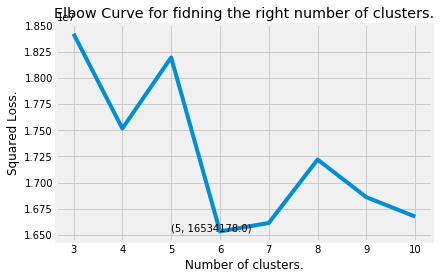

The optimal number of clusters obtained is -  5
The loss for optimal cluster is -  16534178.0


In [36]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    M, C = kmedoids.kMedoids(D, cluster) # Training Clustering.
    squared_errors.append(compute_loss(M, C, tfidf)) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [37]:
M, C = kmedoids.kMedoids(D, k = optimal_clusters) # Using optimal_cluster to best kmedoid.

In [38]:
# Looking at cluster center and a point near them.
q = 0
for i in M:
    print ("Cluster ", q)
    print (" ")
    print (sample_data.iloc[i]['Text'])
    print ("\nA Review belonging to this cluster. -> \n")
    print (sample_data.iloc[C[q][0]]['Text'])
    print ("\n")
    print ("*" * 90)
    q = q + 1

Cluster  0
 
I had a tunnel along my concrete driveway and the grass about 10' long and had 5 mole hills.  I set a trap at both ends.  When I dug into the first mole hill to set the trap I noticed a half eaten grub and placed it on the trigger bar, covered with some dirt, and put a pail over the trap to keep it dark.<br />About 2 hours later I checked the trap and it had sprung. I carefully lifted the trap and a mole was caught in the trap but not dead.  Be ready for that.<br />I have not seen any further evidence of moles but if I use this trap again I will try adding a grub or worm bait to attract them.

A Review belonging to this cluster. -> 

I have a large yard with several moles.  I called a mole/pest removal company.  I hired them and paid 200.00 to have about a dozen traps set (yes, they used these exact traps which is why I ordered some for myself).<br /><br />Anyway, they had 30 days to trap moles in my yard.  They also charged 69.00 for each mole they caught.  They got 5 mol

In [39]:
# Plotting Number of points in each cluster .
counts = []
for key, arr in C.items():
    counts.append(len(arr))
counts

[59, 85, 20, 4828, 8]

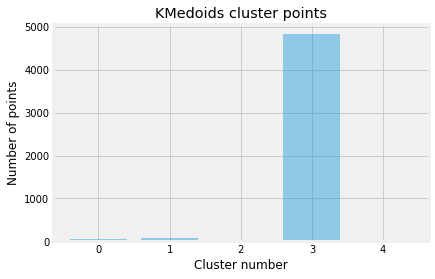

In [40]:
plt.bar([x for x in range(optimal_clusters)], counts, alpha = 0.4)
plt.title('KMedoids cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

** Observations **
1. Most of the points are clustered into the cluster number 3.
2. K-Medoids does not do a decent job at clustering as most of the cluster center and points around them are not similar at all.

### Heirarchical Clustering :

In [41]:
# Checking agglomerative Clustering groupings ->
df = sample_data
for cluster in num_clus:
    agg = AgglomerativeClustering(n_clusters=cluster)
    agg.fit(tfidf.toarray())
    print("*" * 40, "  For Number of Clusters = ", cluster, "  ", "*" * 40)
    print("\nReviews for each of the clusters : \n")
    df = sample_data
    df['Clst'] = agg.labels_
    df = df.groupby(['Clst'])
    # Printing two reviews from each cluster, if they contain at-least points.
    for i in range(cluster):
        print("For cluster ", i, "\n")
        print("Review 1 -> \n")
        print(sample_data.iloc[df.groups[i][0]]['Text'])
        if(len(df.groups[i]) > 1):
            print("\n")
            print("Review 2 -> \n")
            print(sample_data.iloc[df.groups[i][1]]['Text'])
        print("-" * 80)
    
    print("_" * 80)
    print("\n")

****************************************   For Number of Clusters =  3    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

Set in a small New England town, Tim Burton's masterpiece &quot;Beetlejuice&quot; follows the life of Adam and Barbara Maitlin, owners of a large house and small hardware store. While taking a vacation at home, the couple drowns in a mishap car accident. When their home is taken over by boisterous city-folk, they turn in several directions for help  in haunting the Deets family. One such prospective poltergeist is Beetlejuice- brilliantly played by Michael Keaton. <p>Featuring a star-studded cast including a young Winona Ryder, Geena Davis, Alec Baldwin and of course Keaton, the storyline boasts creative, believable characters simply not seen in movies these days. <p>Everything in the storyline is clever, from props to costumes right down the score. One of my absolute favorite films!


Review 2 -> 

Halle

****************************************   For Number of Clusters =  4    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

Set in a small New England town, Tim Burton's maste

****************************************   For Number of Clusters =  5    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

I bought one of these to start and both my dogs loved it, so I bought another one so they didn't have to try and share one. I got lucky and actually ended up with two different styles of dinosaur. I love nylabone products and will probably put another dino in my amazon cart soon!


Review 2 -> 

I have a six month pup that is about 35 pounds and chews EVERYTHING!  Totally demolishes whatever she can get her hands on!  I'm hoping this helps satisfy her chewing needs without being destroyed. It looks great and is exactly what I was wanting so fingers are crossed! :-)
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

Set in a small New England town, Tim Burton's masterpiece &quot;Beetlejuice&quot; follows the life of Adam and Barbara Maitlin, owne

****************************************   For Number of Clusters =  6    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

Set in a small New England town, Tim Burton's maste

****************************************   For Number of Clusters =  7    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

Set in a small New England town, Tim Burton's masterpiece &quot;Beetlejuice&quot; follows the life of Adam and Barbara Maitlin, owners of a large house and small hardware store. While taking a vacation at home, the couple drowns in a mishap car accident. When their home is taken over by boisterous city-folk, they turn in several directions for help  in haunting the Deets family. One such prospective poltergeist is Beetlejuice- brilliantly played by Michael Keaton. <p>Featuring a star-studded cast including a young Winona Ryder, Geena Davis, Alec Baldwin and of course Keaton, the storyline boasts creative, believable characters simply not seen in movies these days. <p>Everything in the storyline is clever, from props to costumes right down the score. One of my absolute favorite films!


Review 2 -> 

Halle

****************************************   For Number of Clusters =  8    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

These liver treas are phenomenal. When i received the 14oz. bucket by amazon i began training my 3month old Alaskan malamute. Now that a month has passed by, she now knows: Sit, Stay, Down, Paw, & SPEAK! My bucket is almost empty as it only lasted for about a month but was worth every penny as ive read malamutes are very stubborn quite dogs. I gave some to my 2 poodles where they gobbled it down and were begging for more. These treats are highly recommended, plus the liver cubes can be further broken down into quadrants. A+++ product


Review 2 -> 

No waste , even if she is having a  day when she goes on a hunger strike  she always room for one or 2 or 3 of these and the extra powder on bottom makes a real treat on food , Never met a pooch that did not go crazy over her treats !
-------------------------

****************************************   For Number of Clusters =  9    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

My dogs love Zuke's Hip Action Treats.<br /><br />I don't know if you realized it or not but the individual bags you were selling were cheaper than the three pack.


Review 2 -> 

My two Chihuahuas absolutely love these treats. They get one at bedtime and follow me around until I give it to them. These are great healthy moist treats for a good price. Would highly recommend.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

These seems to work as promised. I have used one for years and recently had to replace, due to changing circumstances. This model comes with 4 stoppers, and the pump is attractive and well made. Since I almost never finish a whole bottle of wine, one of these is essential for preserving the remainder.


Review 2 -> 

If you'r

****************************************   For Number of Clusters =  10    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

These seems to work as promised. I have used one for years and recently had to replace, due to changing circumstances. This model comes with 4 stoppers, and the pump is attractive and well made. Since I almost never finish a whole bottle of wine, one of these is essential for preserving the remainder.


Review 2 -> 

If you're new to this product you need to be very careful of dosage. It is strong. Some batches are stronger than others.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

My dogs love Zuke's Hip Action Treats.<br /><br />I don't know if you realized it or not but the individual bags you were selling were cheaper than the three pack.


Review 2 -> 

My two Chihuahuas absolutely love these treats. They get one at bedtime and follow

** Conclusions **
> Reading through some of the reviews of cluster , it seems that some different reviews are put together in the same cluster just like in the case of BoW.<br>
But apart from a few of such points , this model does a good job clustering them.

## Word2Vec :

In [42]:
# removing html tags and apostrophes if present.
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    sentence = sentence.decode('utf-8')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [43]:
i=0
list_of_sent_train=[]
for sent in sample_data['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [44]:
# Training the wor2vec model using train dataset
w2v_model=gensim.models.Word2Vec(list_of_sent_train,size=100, workers=4) 

## AVG-W2V :

In [45]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


(5000, 100)

### K-Means :

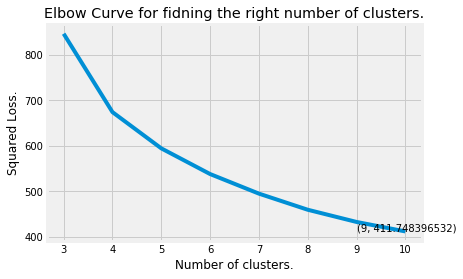

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  411.748396532


In [46]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster).fit(sent_vectors) # Training Clustering.
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [47]:
# Training the best model --
model = KMeans(n_clusters = optimal_clusters)
model.fit(sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [48]:
# Giving Labels/assigning a cluster to each point/text 
df = sample_data
df['AVG-W2V Clus Label'] = model.labels_
df.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText,Bow Clus Label,Clst,Tfidf Clus Label,AVG-W2V Clus Label
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,8,6,7,2
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...,8,6,7,3


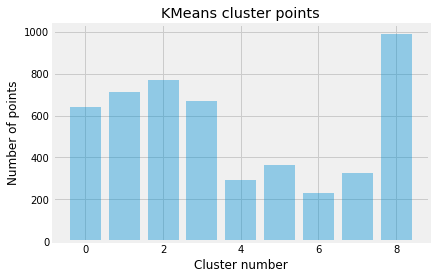

In [49]:
plt.bar([x for x in range(optimal_clusters)], df.groupby(['AVG-W2V Clus Label'])['Text'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [50]:
# Reading a review which belong to each group.
for i in range(optimal_clusters):
    print("A review of assigned to cluster ", i)
    print("-" * 70)
    print(df.iloc[df.groupby(['AVG-W2V Clus Label']).groups[i][0]]['Text'])
    print('\n')
    print("_" * 70)

A review of assigned to cluster  0
----------------------------------------------------------------------
I have been feeding my greyhounds these treats for years.  My hounds can be a little finicky, but they love these treats.  They are expensive, relative to other biscuits, but I find they are a good addition to their diet.  The treats are easy on the teeth.  Since they are protein treat, be careful not to overindulge your pet on a regular basis.  They are great treats to take on walks as you can stuff them in your pocket easily.  I have found prices can vary from vendor to vendor, so shop around.


______________________________________________________________________
A review of assigned to cluster  1
----------------------------------------------------------------------
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we'

**Conclusions**
1. Seems KMEANS for AVG-W2V workd as good as the other too maybe a bit better but not that much.
2. Optimal Clusters found are - 9
3. Loss - 411.74
<br>

### K-Medoids :

In [51]:
# Computing pariwise distances.
D = pairwise_distances(sent_vectors, metric='euclidean')
D.shape

(5000, 5000)

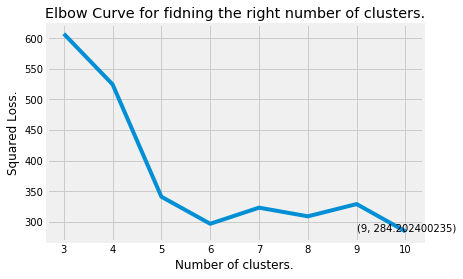

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  284.202400235


In [52]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    M, C = kmedoids.kMedoids(D, cluster) # Training Clustering.
    squared_errors.append(compute_loss(M, C, sent_vectors)) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [53]:
M, C = kmedoids.kMedoids(D, k = optimal_clusters) # Using optimal_cluster to best kmedoid.

In [54]:
# Looking at cluster center and a point near them.
q = 0
for i in M:
    print ("Cluster ", q)
    print (" ")
    print (sample_data.iloc[i]['Text'])
    print ("\nA Review belonging to this cluster. -> \n")
    print (sample_data.iloc[C[q][0]]['Text'])
    print ("\n")
    print ("*" * 90)
    q = q + 1

Cluster  0
 
I needed a very good product for my dogs in the Vetri-Science Glyco-Flex Stage II joint support.  This product came highly recommended from my Vet.  I reviewed the Amazon site for what I thought was a good price when the Ad showed 2 bottles of the product.  I thought I was getting two bottles for the price.  I only received One bottle.  I wrote the company customer Services who agreed that the two bottles was misleading and they would get back to me the next day after she talked to her supervisor.  That was on December 13 and today is December 23 and still no response, even after 3 other emails from me.  This company is very, very poor in customer service as well and misleading in their ads.  I believe that Amazon is partially at blame for this problem and that this company should no longer be able to sell their products from Amazon Market.  Avoid PetFoodDirect.com because you will get taken.

A Review belonging to this cluster. -> 

These liver treas are phenomenal. When 

In [55]:
# Plotting Number of points in each cluster .
counts = []
for key, arr in C.items():
    counts.append(len(arr))
counts

[370, 226, 372, 119, 508, 1104, 991, 519, 791]

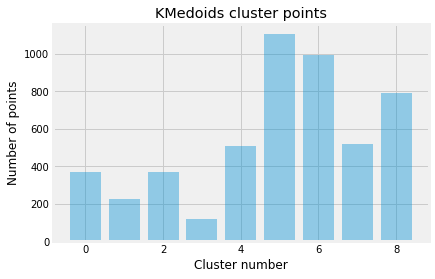

In [56]:
plt.bar([x for x in range(optimal_clusters)], counts, alpha = 0.4)
plt.title('KMedoids cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

**Conclusions **
1. Cluster number 5 has the most number of points.
2. Cluster number 3 has the least number of points.
3. Optimal Clusters - 9
4. Loss - 284.20
<br>
### Heirarchical Clustering :

In [57]:
# Checking agglomerative Clustering groupings ->
df = sample_data
for cluster in num_clus:
    agg = AgglomerativeClustering(n_clusters=cluster)
    agg.fit(sent_vectors)
    print("*" * 40, "  For Number of Clusters = ", cluster, "  ", "*" * 40)
    print("\nReviews for each of the clusters : \n")
    df = sample_data
    df['Clst'] = agg.labels_
    df = df.groupby(['Clst'])
    # Printing two reviews from each cluster, if they contain at-least points.
    for i in range(cluster):
        print("For cluster ", i, "\n")
        print("Review 1 -> \n")
        print(sample_data.iloc[df.groups[i][0]]['Text'])
        if(len(df.groups[i]) > 1):
            print("\n")
            print("Review 2 -> \n")
            print(sample_data.iloc[df.groups[i][1]]['Text'])
        print("-" * 80)
    
    print("_" * 80)
    print("\n")

****************************************   For Number of Clusters =  3    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

All of my children love this book.  My first grader

****************************************   For Number of Clusters =  6    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

A charming, rhyming book that describes the circums

****************************************   For Number of Clusters =  8    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

A charming, rhyming book that describes the circums

****************************************   For Number of Clusters =  10    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

This was the only treat my dog liked during obedience training and it has remained her favorite ever since.  I haven't met a dog that didn't like this treat!


Review 2 -> 

No waste , even if she is having a  day when she goes on a hunger strike  she always room for one or 2 or 3 of these and the extra powder on bottom makes a real treat on food , Never met a pooch that did not go crazy over her treats !
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  will

## DBSCAN :

In [58]:
from sklearn.cluster import DBSCAN
sample_data_2 = data.sample(25000)
sample_data_2.shape

(25000, 12)

In [59]:
# Getting the AVG-W2V for the cleaned text :
i=0
list_of_sent_train_2=[]
for sent in sample_data_2['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train_2.append(filtered_sentence)

In [60]:
# Training the wor2vec model using train dataset
w2v_model_2=gensim.models.Word2Vec(list_of_sent_train_2,size=100, workers=10)

In [66]:
sent_vectors_2 = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent_train_2: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_2.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_2.append(sent_vec)

sent_vectors_2 = np.array(sent_vectors_2)
sent_vectors_2 = np.nan_to_num(sent_vectors_2)
sent_vectors_2.shape

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


(25000, 100)

In [67]:
# Computing 200th Nearest neighbour distance code.
minPts = 2 * 100
# Lower bound function copied from -> https://gist.github.com/m00nlight/0f9306b4d4e61ba0195f
def lower_bound(nums, target): # This function return the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200thnearestneighbour(x, data): # Returns the distance of 200th nearest neighbour.
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) # computing distances.
        if(len(dists) == 200 and dists[199] > dist): # If distance is larger than current largest distance found.
            l = int(lower_bound(dists, dist)) # Using the lower bound function to get the right position.
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[199] # Dist 199 contains the distance of 200th nearest neighbour.

In [68]:
# Computing the 200th nearest neighbour distance of some point the dataset:
twohundrethneigh = []
for val in sent_vectors_2[:1500]:
    twohundrethneigh.append( compute200thnearestneighbour(val, sent_vectors_2[:1500]) )
twohundrethneigh.sort()

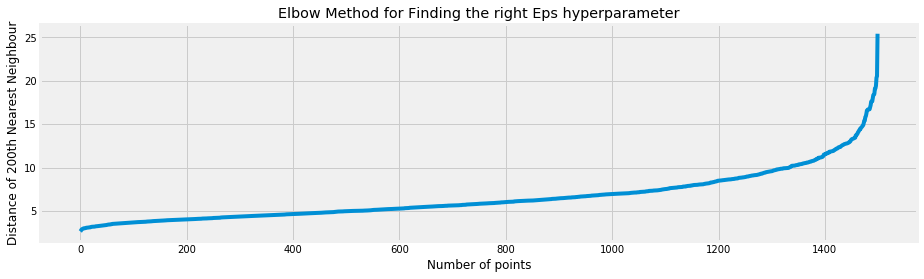

In [69]:
# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

** Conclusions for Elbow Method **
> The Knee point seems to be 10. So Eps  = 10

In [70]:
# Training DBSCAN :
model = DBSCAN(eps = 10, min_samples = minPts, n_jobs=-1)
model.fit(sent_vectors_2)

DBSCAN(algorithm='auto', eps=10, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=200, n_jobs=-1, p=None)

In [71]:
df = sample_data_2
df['AVG-W2V Clus Label'] = model.labels_
df.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,AVG-W2V Clus Label
169208,364650,394347,B001E5E1LE,A3JXADH6D2VUF8,"A.Sai ""tofu review""",1,1,positive,1319414400,"awesome taste, extreme fiber-full!!!",the color if this protein powder is more like ...,b'color protein powder like green drink grass ...,0
95459,155238,168369,B000LDOT58,AIFW5IRNUNOA3,"Guy W. Dearing ""CAG1QM3""",0,0,positive,1227398400,My Dog's Favorite Treat,We picked up the first Busy Buddy Bone at a Gr...,b'pick first busi buddi bone greyhound philade...,0


In [72]:
df.groupby(['AVG-W2V Clus Label'])['Id'].count()

AVG-W2V Clus Label
0    25000
Name: Id, dtype: int64

** Conclusions **
1. Using Elbow method to find the right Eps we get Eps = 10.
2. For EPS = 10 everything is being classified into just one cluster

### TFIDF-W2V :

In [73]:
# We will first create tfidf w2v features.
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(sample_data['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

In [74]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum = 0.0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)
tfidf_sent_vectors.shape

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


(5000, 100)

### K-Means :

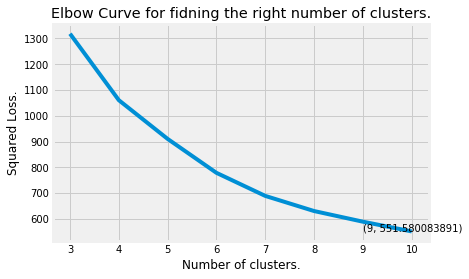

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  551.580083891


In [76]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster).fit(tfidf_sent_vectors) # Training Clustering.
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [78]:
# Training the best model --
model = KMeans(n_clusters = optimal_clusters)
model.fit(tfidf_sent_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [79]:
# Giving Labels/assigning a cluster to each point/text 
df = sample_data
df['TFIDF-W2V Clus Label'] = model.labels_
df.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText,Bow Clus Label,Clst,Tfidf Clus Label,AVG-W2V Clus Label,TFIDF-W2V Clus Label
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,8,1,7,2,1
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...,8,8,7,3,8


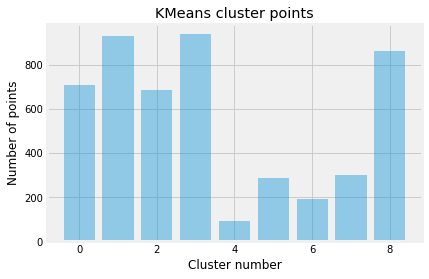

In [80]:
plt.bar([x for x in range(optimal_clusters)], df.groupby(['TFIDF-W2V Clus Label'])['Text'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [81]:
# Reading a review which belong to each group.
for i in range(optimal_clusters):
    print("A review of assigned to cluster ", i)
    print("-" * 70)
    print(df.iloc[df.groupby(['TFIDF-W2V Clus Label']).groups[i][0]]['Text'])
    print('\n')
    print("_" * 70)

A review of assigned to cluster  0
----------------------------------------------------------------------
I've always loved chicken soup and rice. My late great-grandmother, Ethel, always made me homemade chicken, chicken soup and rice. This book takes me back to the days my mother, my father, my sister, and I went to Ethel's house. My late great-grandfather, Isadore, would cook the chicken because Ethel was blind. So, it reminds me of the time we were all together as a family. It brings back happy memories of all the love we shared over bowls of hot soup.


______________________________________________________________________
A review of assigned to cluster  1
----------------------------------------------------------------------
this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all

** Conclusions **
1. Optimal Clusters - 9
2. Loss - 551.58
3. Its the same thing here too just like in Bow and TFIDF cases with the clusters.
<br>

### K-Medoids :-

In [82]:
# Computing pariwise distances.
D = pairwise_distances(tfidf_sent_vectors, metric='euclidean')
D.shape

(5000, 5000)

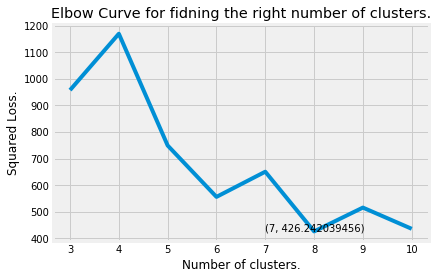

The optimal number of clusters obtained is -  7
The loss for optimal cluster is -  426.242039456


In [83]:
# Choosing the best cluster using Elbow Method.
squared_errors = []
for cluster in num_clus:
    M, C = kmedoids.kMedoids(D, cluster) # Training Clustering.
    squared_errors.append(compute_loss(M, C, tfidf_sent_vectors)) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve for fidning the right number of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [84]:
M, C = kmedoids.kMedoids(D, k = optimal_clusters) # Using optimal_cluster to best kmedoid.

In [85]:
# Looking at cluster center and a point near them.
q = 0
for i in M:
    print ("Cluster ", q)
    print (" ")
    print (sample_data.iloc[i]['Text'])
    print ("\nA Review belonging to this cluster. -> \n")
    print (sample_data.iloc[C[q][0]]['Text'])
    print ("\n")
    print ("*" * 90)
    q = q + 1

Cluster  0
 
I originally bought the Zuke's Treats for Cats on Amazon.com. It arrived in a decent amount of time (I didn't expect it to be quick since I used the free shipping). My cat thought they were just okay, and would eat them if i put them in front of her, but not come running as she does for her other treats. So I would leave them out for her in her dish, and they would get hard real quick. After maybe eating 5-20 of the little pieces total, she stopped eating them altogether, and walked AWAY when i got out the treats.<br />Then I went to Petco after adopting a puppy, and Petco convinced me they would be perfect for training so i got the ones for dogs. I thought maybe the shipping made them stale, and Petco assured me the ones for dogs were of better quality. Unfortunately this was not the case, my dog who eats shoes, and ANYTHING else that's on the floor does not want to eat these. I mean they are okay but barely okay. When I take her on walks and use them to redirect her atte

In [86]:
# Plotting Number of points in each cluster .
counts = []
for key, arr in C.items():
    counts.append(len(arr))
counts

[814, 1109, 1123, 374, 748, 271, 561]

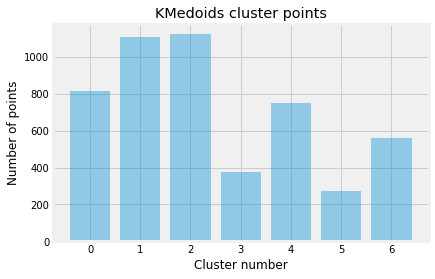

In [87]:
plt.bar([x for x in range(optimal_clusters)], counts, alpha = 0.4)
plt.title('KMedoids cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

** Conclusions **
1. Cluster number 2 has most reviews.
2. Optimal number of clusters - 7
3. Loss - 426.24

<br>

### Heirarchical Clustering :-

In [88]:
# Checking agglomerative Clustering groupings ->
df = sample_data
for cluster in num_clus:
    agg = AgglomerativeClustering(n_clusters=cluster)
    agg.fit(tfidf_sent_vectors)
    print("*" * 40, "  For Number of Clusters = ", cluster, "  ", "*" * 40)
    print("\nReviews for each of the clusters : \n")
    df = sample_data
    df['Clst'] = agg.labels_
    df = df.groupby(['Clst'])
    # Printing two reviews from each cluster, if they contain at-least points.
    for i in range(cluster):
        print("For cluster ", i, "\n")
        print("Review 1 -> \n")
        print(sample_data.iloc[df.groups[i][0]]['Text'])
        if(len(df.groups[i]) > 1):
            print("\n")
            print("Review 2 -> \n")
            print(sample_data.iloc[df.groups[i][1]]['Text'])
        print("-" * 80)
    
    print("_" * 80)
    print("\n")

****************************************   For Number of Clusters =  3    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

What can I say? This is a CLASSIC! I've seen this m

****************************************   For Number of Clusters =  4    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

What can I say? This is a CLASSIC! I've seen this m

****************************************   For Number of Clusters =  5    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

These liver treas are phenomenal. When i received the 14oz. bucket by amazon i began training my 3month old Alaskan malamute. Now that a month has passed by, she now knows: Sit, Stay, Down, Paw, & SPEAK! My bucket is almost empty as it only lasted for about a month but was worth every penny as ive read malamutes are very stubborn quite dogs. I gave some to my 2 poodles where they gobbled it down and were begging for more. These treats are highly recommended, plus the liver cubes can be further broken down into quadrants. A+++ product


Review 2 -> 

This was the only treat my dog liked during obedience training and it has remained her favorite ever since.  I haven't met a dog that didn't like this treat!
--------------------------------------------------------------------------------
For cluster  1 

Revi

****************************************   For Number of Clusters =  6    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

This book is a family favorite and was read to my children over and over again when they were small.  We ordered it for a new mom-to-be so that she and her family can enjoy it too!


Review 2 -> 

Great book, perfect condition arrived in a short amount of time, long before the expected delivery date
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up r

****************************************   For Number of Clusters =  7    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

What can I say? This is a CLASSIC! I've seen this m

****************************************   For Number of Clusters =  8    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

What can I say? This is a CLASSIC! I've seen this movie so many times I actually have most of the words memorized. This movie is hilariously funny, but at the same time it has a touch of drama in it. It's an all around great movie.<p>Michael Keaton does an excellent job of playing the odd, funny, and perverted Beetlejuice who causes quite the chaos with a newly deceased couple, Adam and Barbara. Let me just say no one and I mean NO ONE could've been better for the part of Beetlejuice.<p>The only disapointting thing about the DVD Beetljuice is there were no deleted scenes or extra footage.. I was disapointed, but I love this movie so much it was still worth it!<p>If you haven't seen Beetlejuice, then YOU MUST SEE IT. And for all the Beetlejuice lovers and fans out there this is a must have to your video or

****************************************   For Number of Clusters =  9    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


Review 2 -> 

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
--------------------------------------------------------------------------------
For cluster  1 

Review 1 -> 

When I first go my Havanese puppy 1 1/2 years ago, 

****************************************   For Number of Clusters =  10    ****************************************

Reviews for each of the clusters : 

For cluster  0 

Review 1 -> 

When I first go my Havanese puppy 1 1/2 years ago, the breeder suggested these liver treats for using when training.  My dog will do ANYTHING for these treats.  They even use them at the name brand pet hotel we use in Phoenix.  You have to be careful not to give too much, but my dog, Tanner, got over his separation anxiety when I started the routine of asking for a kiss, then giving him a treat and then leaving.  Now he just wants the treat, I have to beg for the kiss.


Review 2 -> 

It was on the other night, and, having been a big fan of the cartoon when it was being shown, decided to watch it (I'm also trying to see all the Winona Ryder movies I know.). <p> It's a well known fact i like seeing her [Winona Ryder] dance at the end of a movie (hey, it's funny!), but apart from that, it was just a hilari

### DBSCAN :

In [89]:
# We will first create tfidf w2v features.
tf_idf_vect_2 = TfidfVectorizer()
final_tf_idf_2 = tf_idf_vect_2.fit_transform(sample_data_2['CleanedText'].values)
tfidf_feat_2 = tf_idf_vect_2.get_feature_names() # tfidf words/col-names

In [90]:
tfidf_sent_vectors_2 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train_2: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum = 0.0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_2.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf_2[row, tfidf_feat_2.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_2.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_2 = np.array(tfidf_sent_vectors_2)
tfidf_sent_vectors_2 = np.nan_to_num(tfidf_sent_vectors_2)
tfidf_sent_vectors_2.shape

/opt/conda/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


(25000, 100)

In [91]:
# Computing the 200th nearest neighbour distance of some point the dataset:
twohundrethneigh = []
for val in tfidf_sent_vectors_2[:1500]:
    twohundrethneigh.append( compute200thnearestneighbour(val, tfidf_sent_vectors_2[:1500]) )
twohundrethneigh.sort()

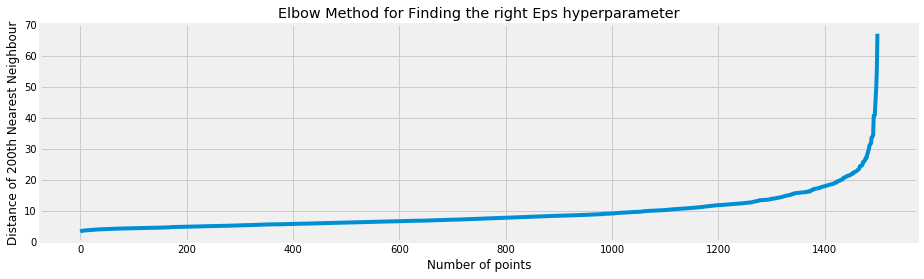

In [92]:
# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()

In [93]:
# Training DBSCAN :
model = DBSCAN(eps = 20, min_samples = minPts, n_jobs=-1)
model.fit(tfidf_sent_vectors_2)

DBSCAN(algorithm='auto', eps=20, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=200, n_jobs=-1, p=None)

In [94]:
df = sample_data_2
df['TFIDF-W2V Clus Label'] = model.labels_
df.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,AVG-W2V Clus Label,TFIDF-W2V Clus Label
169208,364650,394347,B001E5E1LE,A3JXADH6D2VUF8,"A.Sai ""tofu review""",1,1,positive,1319414400,"awesome taste, extreme fiber-full!!!",the color if this protein powder is more like ...,b'color protein powder like green drink grass ...,0,0
95459,155238,168369,B000LDOT58,AIFW5IRNUNOA3,"Guy W. Dearing ""CAG1QM3""",0,0,positive,1227398400,My Dog's Favorite Treat,We picked up the first Busy Buddy Bone at a Gr...,b'pick first busi buddi bone greyhound philade...,0,0


In [95]:
df.groupby(['TFIDF-W2V Clus Label'])['Id'].count()

TFIDF-W2V Clus Label
0    25000
Name: Id, dtype: int64

** Conclusions **
1. Knee point found is 20.
2. Just ike with AVG-W2V DBSCAN everything is being clustered into just one cluster.